In [1]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

## Image Augmentation

In [2]:
url = "dataset-out"

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   rescale=1./255,
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 64
img_size = (128, 128)

train_set = train_datagen.flow_from_directory(url + '/train', 
                                              class_mode='sparse',
                                              batch_size = batch_size,
                                              target_size=img_size,)

val_set = test_datagen.flow_from_directory(url + '/val',
                                           class_mode='sparse',
                                           batch_size = batch_size,
                                           target_size=img_size,)

test_set = test_datagen.flow_from_directory(url + '/test',
                                            class_mode='sparse',
                                           batch_size = batch_size,
                                           shuffle=False,
                                           target_size=img_size)

Found 2219 images belonging to 7 classes.
Found 276 images belonging to 7 classes.
Found 283 images belonging to 7 classes.


In [3]:
class_to_index = train_set.class_indices
index_to_class = {v: k for k, v in class_to_index.items()}

print(class_to_index)
print(index_to_class)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5, 'trash': 6}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'organic', 4: 'paper', 5: 'plastic', 6: 'trash'}


## Base Model

In [ ]:
model1 = keras.models.Sequential([
    keras.layers.Input(shape=(128,128,3)),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(padding='same'),
    keras.layers.BatchNormalization(),

    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation='softmax'),
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model1.summary()

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=2)
checkpoint = keras.callbacks.ModelCheckpoint('my_model', save_best_only=True)

hist = model1.fit(train_set, validation_data=val_set, epochs=20, callbacks=[early_stopping, checkpoint])

## Transfer Learning with MobileNetV2

In [4]:
baseModel = keras.applications.MobileNetV2(input_shape=(128, 128, 3), weights='imagenet',
                                           include_top=False)

for layers in baseModel.layers:
    layers.trainable=False

In [5]:
model = keras.models.Sequential([
    baseModel,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dropout(0.2),
    keras.layers.Dense(7, activation='softmax'),
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])

epochs=50
callbacks = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dropout (Dropout)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 128)               2621568   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                        

In [6]:
history = model.fit(train_set, validation_data=val_set, epochs=epochs, callbacks=[callbacks])

Epoch 1/50
35/35 [==============================] - 26s 660ms/step - loss: 1.7782 - accuracy: 0.5020 - val_loss: 0.9065 - val_accuracy: 0.7029
Epoch 2/50
35/35 [==============================] - 19s 544ms/step - loss: 0.9338 - accuracy: 0.6634 - val_loss: 0.7282 - val_accuracy: 0.7609
Epoch 3/50
35/35 [==============================] - 19s 541ms/step - loss: 0.7976 - accuracy: 0.7021 - val_loss: 0.6441 - val_accuracy: 0.7899
Epoch 4/50
35/35 [==============================] - 18s 523ms/step - loss: 0.7491 - accuracy: 0.7265 - val_loss: 0.7056 - val_accuracy: 0.7609
Epoch 5/50
35/35 [==============================] - 18s 515ms/step - loss: 0.7252 - accuracy: 0.7418 - val_loss: 0.6651 - val_accuracy: 0.7609
Epoch 6/50
35/35 [==============================] - 18s 514ms/step - loss: 0.6576 - accuracy: 0.7661 - val_loss: 0.5715 - val_accuracy: 0.7717
Epoch 7/50
35/35 [==============================] - 18s 518ms/step - loss: 0.6117 - accuracy: 0.7684 - val_loss: 0.6133 - val_accuracy: 0.8080

#### Training process evaluating

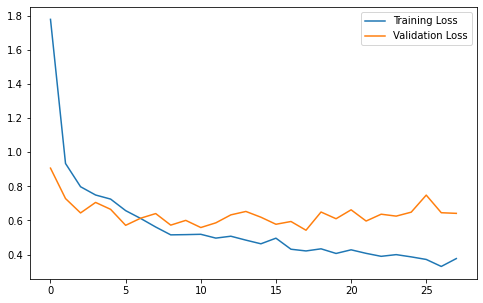

In [7]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])

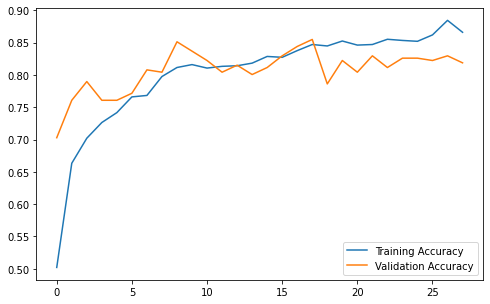

In [8]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])

## Validation Test

In [9]:
train_set = test_datagen.flow_from_directory(url + '/train',
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

val_set   = test_datagen.flow_from_directory(url + '/test',
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            target_size=img_size)

Found 2219 images belonging to 7 classes.
Found 283 images belonging to 7 classes.


### Train Loss vs Validation Loss

In [11]:
print("Training loss - Accuracy")
model.evaluate(train_set)
print("Validation loss - Accuracy")
model.evaluate(val_set)
print()

Training loss - Accuracy
35/35 [==============================] - 12s 352ms/step - loss: 0.2197 - accuracy: 0.9211
Validation loss - Accuracy
5/5 [==============================] - 2s 296ms/step - loss: 0.6200 - accuracy: 0.8304



### Precision, Recall, F1-score, and Confusion Matrix

In [15]:
target_names = list(test_set.class_indices.keys())

def evaluate(y, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))

    cm = confusion_matrix(y, y_pred)

    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    cmp.plot(ax=ax, cmap='Blues')
    fig.show()

    print(classification_report(y, y_pred, digits=5, target_names=target_names))

#### Train set

35/35 [==============================] - 13s 355ms/step
              precision    recall  f1-score   support

   cardboard    0.93353   0.95963   0.94640       322
       glass    0.89639   0.93000   0.91288       400
       metal    0.90087   0.94207   0.92101       328
     organic    0.98477   0.97000   0.97733       200
       paper    0.93061   0.96000   0.94508       475
     plastic    0.95122   0.81039   0.87518       385
       trash    0.80000   0.84404   0.82143       109

    accuracy                        0.92114      2219
   macro avg    0.91391   0.91659   0.91419      2219
weighted avg    0.92251   0.92114   0.92061      2219



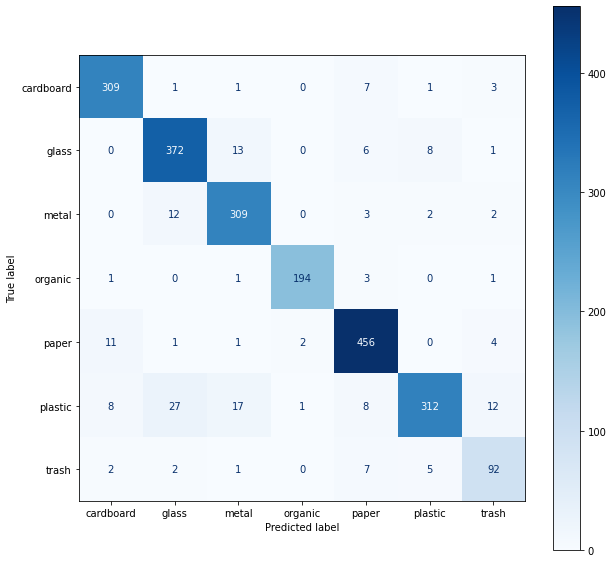

In [16]:
y = train_set.labels
y_pred = np.argmax(model.predict(train_set), axis=1)
evaluate(y, y_pred)

#### Validation set

5/5 [==============================] - 2s 303ms/step
              precision    recall  f1-score   support

   cardboard    0.83721   0.87805   0.85714        41
       glass    0.81818   0.88235   0.84906        51
       metal    0.78261   0.87805   0.82759        41
     organic    0.96000   0.92308   0.94118        26
       paper    0.77612   0.86667   0.81890        60
     plastic    0.94118   0.65306   0.77108        49
       trash    0.76923   0.66667   0.71429        15

    accuracy                        0.83039       283
   macro avg    0.84065   0.82113   0.82560       283
weighted avg    0.83860   0.83039   0.82854       283



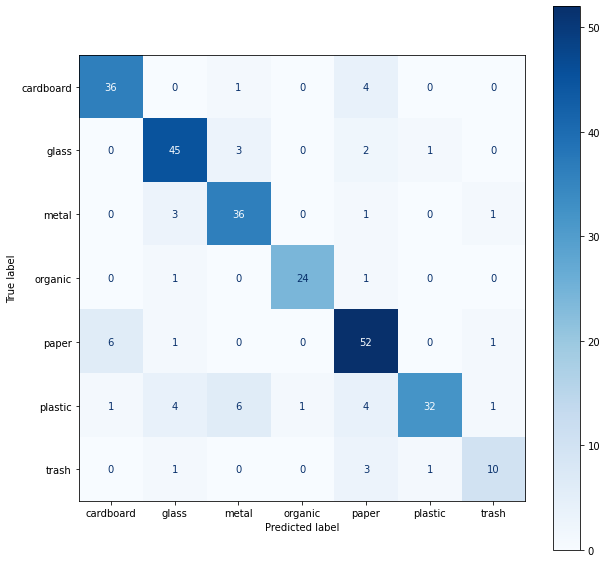

In [17]:
y = val_set.labels
y_pred = np.argmax(model.predict(val_set), axis=1)
evaluate(y, y_pred)

## Final Evaluation on Test set

### Classification Report and Confusion Matrix

5/5 [==============================] - 2s 340ms/step
              precision    recall  f1-score   support

   cardboard    0.83721   0.87805   0.85714        41
       glass    0.81818   0.88235   0.84906        51
       metal    0.78261   0.87805   0.82759        41
     organic    0.96000   0.92308   0.94118        26
       paper    0.77612   0.86667   0.81890        60
     plastic    0.94118   0.65306   0.77108        49
       trash    0.76923   0.66667   0.71429        15

    accuracy                        0.83039       283
   macro avg    0.84065   0.82113   0.82560       283
weighted avg    0.83860   0.83039   0.82854       283



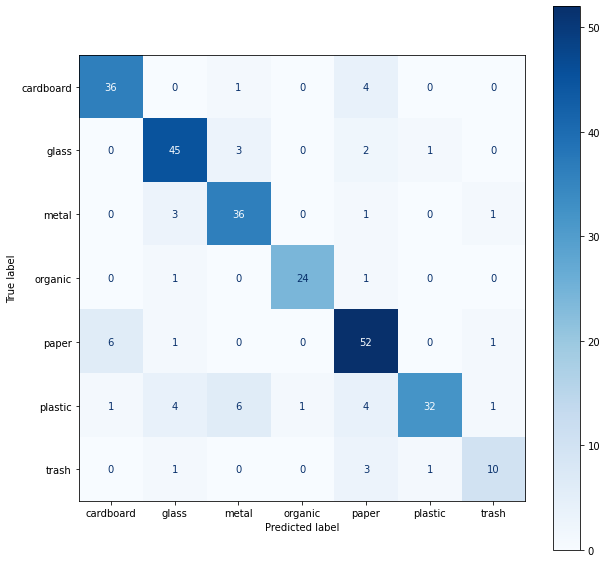

In [18]:
y = test_set.labels
y_pred = np.argmax(model.predict(test_set), axis=1)
evaluate(y, y_pred)

### Random Sample Test

In [19]:
def test():
    batch = np.random.randint(0, len(test_set)-1)
    data = 0
    img = np.random.randint(0, len(test_set[batch][data])-1)
    IMAG = test_set[batch][data][img]

    plt.imshow(IMAG)
    plt.show()
    pred = model.predict(IMAG.reshape(1, 128, 128, 3))
    probability = pred.max()
    index = np.argmax(pred)
    label = index_to_class.get(index)
    print(f"Model predicts {label.capitalize()} with probability {probability}")
    

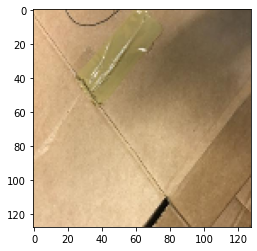

1/1 [==============================] - 1s 1s/step
Model predicts Cardboard with probability 0.9999979734420776


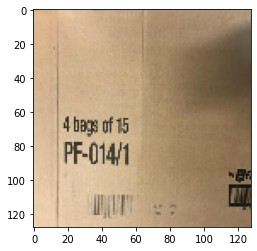

1/1 [==============================] - 0s 35ms/step
Model predicts Cardboard with probability 0.9999998807907104


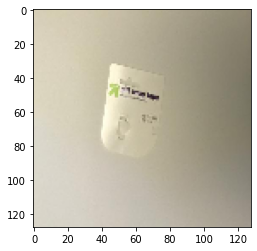

1/1 [==============================] - 0s 36ms/step
Model predicts Paper with probability 0.9980442523956299


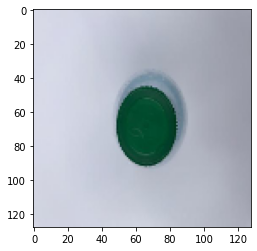

1/1 [==============================] - 0s 31ms/step
Model predicts Plastic with probability 0.9820706844329834


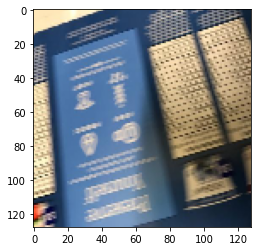

1/1 [==============================] - 0s 58ms/step
Model predicts Paper with probability 0.7902613878250122


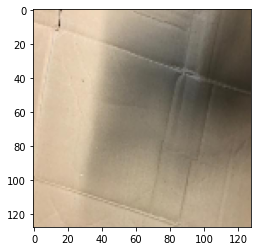

1/1 [==============================] - 0s 33ms/step
Model predicts Cardboard with probability 1.0


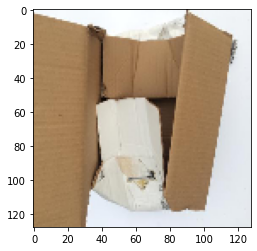

1/1 [==============================] - 0s 32ms/step
Model predicts Cardboard with probability 0.9999644756317139


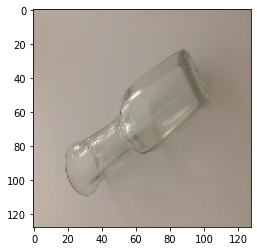

1/1 [==============================] - 0s 37ms/step
Model predicts Glass with probability 0.9842253923416138


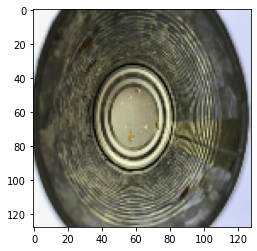

1/1 [==============================] - 0s 33ms/step
Model predicts Metal with probability 0.9991260170936584


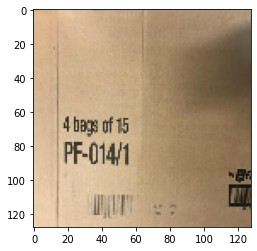

1/1 [==============================] - 0s 34ms/step
Model predicts Cardboard with probability 0.9999998807907104


In [20]:
for i in range(10):
    test()

## Save model

In [21]:
model.save("waste_classifier_v2")

INFO:tensorflow:Assets written to: waste_classifier_v2\assets


INFO:tensorflow:Assets written to: waste_classifier_v2\assets
